In [1]:
from datetime import date
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
df = pd.read_csv("../Resources/btcjoin.csv", parse_dates=['date'])
btc_df = yf.Ticker('BTC-USD').history(period='7y',interval='1d',actions=False).reset_index()
btc_df = btc_df.loc[(btc_df['Date'] > '2022-10-25')]
btc_df['Close']=btc_df['Close'].astype("float")
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
btc_df = btc_df.rename(columns={"Close": "price", "Date":"date"})
df = pd.merge(df, btc_df, on=['date', 'price'], how='outer')
df = df.rename(columns={"value": "wallets"})
df = df.drop(columns=['volume','change', 'low', 'high', 'open','Open','High','Low','Unnamed: 0', "wallets", "address", "mined"])
df['200D'] = df['price'].rolling(200).mean()
df['300D'] = df['price'].rolling(300).mean()
df['50D'] = df['price'].rolling(50).mean()
# df = df.dropna()
df['meanavge'] = (df['200D'] + df['300D'] + df['50D'] )/3
df = df.drop(columns=['200D','300D', '50D'])
df['meanvalue'] = df["price"] - df["meanavge"]
df['status'] = df['meanvalue'].apply(lambda x: '1' if x > 0 else '0')
df['status']=df['status'].astype("object")
df['price-meanavge']=df['price'] - df['meanavge']
df['move%'] = 100*(df['price-meanavge']/(df['price'] + df['meanavge']))
bins = [-43, -18, 0, 18, 43]
group_names = ["Severely Oversold","Neutral Oversold", "Neutral Overbought","Severely Overbought"]
df["Valuation"] = pd.cut(df["move%"], bins, labels=group_names)

k = df['price'].ewm(span=12, adjust=False, min_periods=12).mean()

# Get the 12-day EMA of the closing price
d = df['price'].ewm(span=26, adjust=False, min_periods=26).mean()

# Subtract the 26-day EMA from the 12-Day EMA to get the MACD
macd = k - d

# Get the 9-Day EMA of the MACD for the Trigger line
macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()

# Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
macd_h = macd - macd_s

# Add all of our new values for the MACD to the dataframe
df['macd'] = df.index.map(macd)
df['macd_h'] = df.index.map(macd_h)
df['macd_s'] = df.index.map(macd_s)

df

date         price        Volume      meanavge    meanvalue status  \
0    2010-09-25      0.100000           NaN           NaN          NaN      0   
1    2010-09-26      0.100000           NaN           NaN          NaN      0   
2    2010-09-27      0.100000           NaN           NaN          NaN      0   
3    2010-09-28      0.100000           NaN           NaN          NaN      0   
4    2010-09-29      0.100000           NaN           NaN          NaN      0   
...         ...           ...           ...           ...          ...    ...   
4507 2023-02-24  23198.126953  2.681174e+10  21181.893054  2016.233899      1   
4508 2023-02-25  23175.375000  1.610072e+10  21206.446193  1968.928807      1   
4509 2023-02-26  23561.212891  1.664453e+10  21233.203405  2328.009486      1   
4510 2023-02-27  23522.871094  2.266076e+10  21259.621835  2263.249259      1   
4511 2023-02-28  23232.800781  2.059149e+10  21279.636755  1953.164026      1   

      price-meanavge     move%           Valuation        macd      macd_h  \
0                NaN       NaN                 NaN         NaN         NaN   
1                NaN       NaN                 NaN         NaN         NaN   
2                NaN       NaN                 NaN         NaN         NaN   
3                NaN       NaN                 NaN         NaN         NaN   
4                NaN       NaN                 NaN         NaN         NaN   
...              ...       ...                 ...         ...         ...   
4507     2016.233899  4.543112  Neutral Overbought  568.123803  -63.857078   
4508     1968.928807  4.436341  Neutral Overbought  479.527266 -121.962892   
4509     2328.009486  5.197097  Neutral Overbought  435.428418 -132.849393   
4510     2263.249259  5.053871  Neutral Overbought  392.857286 -140.336420   
4511     1953.164026  4.387906  Neutral Overbought  331.887317 -161.045111   

          macd_s  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
...          ...  
4507  631.980881  
4508  601.490158  
4509  568.277810  
4510  533.193705  
4511  492.932427  

[4512 rows x 12 columns]

17:51:54 - cmdstanpy - INFO - Chain [1] start processing
17:51:56 - cmdstanpy - INFO - Chain [1] done processing


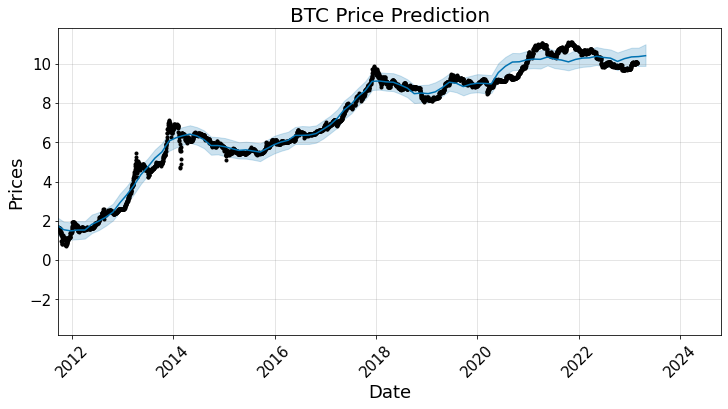

In [2]:
## Combine with Prophet
from datetime import timedelta, date
from prophet import Prophet
df['priceL'] = np.log(df['price'])

df_train = df[['date', 'priceL']]
df_train = df_train.rename(columns = {"date":"ds", "priceL":"y"})

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

start = "2010-09-25"
end = date.today() + timedelta(days=60)
insample = pd.DataFrame(pd.date_range(start,end, periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("BTC Price Prediction", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Prices", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2011-09-25', '2024-10-24'])) 
plt.show();

In [3]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["red","green","blue","orange"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
fig.add_trace(go.Scatter(x=prediction['ds'], y=np.exp(prediction['yhat']),
    fill=None,
    mode='lines',
    line_color='lightblue',
    ))
fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_lower']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_upper']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prophet Model + Buy Zones')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")
fig.layout.template = 'seaborn'	
fig.show()
fig.write_html('../static/combo.html')

In [4]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.bar(df, x="date", y="price", color="Valuation", color_discrete_sequence=["red","green","blue","orange"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Buy Zones 2.0')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.update_layout(showlegend=True)
fig.update_traces(dict(marker_line_width=.01))
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/buyzones2.html')

In [5]:
from datetime import date
from datetime import datetime

d1 = str(int(df.price[df['date']=='2014-01-06'].tolist()[0]/df.price[df['date']=='2011-11-25'].tolist()[0]*100)) +"%"
d2 = str(int(-100*(1-(df.price[df['date']=='2015-10-05'].tolist()[0]/df.price[df['date']=='2014-01-07'].tolist()[0])))) + "%"
d3 = str(int(df.price[df['date']=='2018-01-06'].tolist()[0]/df.price[df['date']=='2015-10-06'].tolist()[0]*100)) +"%"
d4 = str(int(-100*(1-(df.price[df['date']=='2019-03-30'].tolist()[0]/df.price[df['date']=='2018-01-07'].tolist()[0])))) + "%"
d5 = str(int(df.price[df['date']=='2021-11-08'].tolist()[0] / df.price[df['date']=='2019-04-01'].tolist()[0] *100)) + "%"
d6 = str(int(-100*(1-(df.price[df['date']== df.date.iloc[-1]].tolist()[0]/df.price[df['date']=='2021-11-09'].tolist()[0])))) + "%"
d7 = str(int(-100*(1-(df.price[df['date']== df.date.iloc[-1]].tolist()[0]/df.price[df['date']=='2023-01-14'].tolist()[0])))) + "%"

import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["red","green","blue","orange"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
fig.add_trace(go.Scatter(x=prediction['ds'], y=np.exp(prediction['yhat']),
    fill=None,
    mode='lines',
    line_color='lightblue',
    ))
fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_lower']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_upper']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.add_vrect(x0="2011-11-25", x1="2014-01-06", 
              annotation_text=str((date(2014, 2, 4)-date(2011, 11, 25)).days) + " days " + str(d1), annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2014-01-07", x1="2015-10-05", 
              annotation_text=str((date(2015, 10, 7)-date(2014, 2, 5)).days) + " days " + str(d2), annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect(x0="2015-10-06", x1="2018-01-06", 
              annotation_text=str((date(2018, 1, 18)-date(2015, 10, 6)).days) +" days " + str(d3), annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2018-01-07", x1="2019-03-30", 
              annotation_text=str((date(2019, 3, 30)-date(2018, 1, 18)).days) + " days " + str(d4), annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect(x0="2019-04-01", x1="2021-11-08", 
              annotation_text=str((date(2021, 11, 8)-date(2019, 4, 1)).days) + " days " + str(d5), annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-09", x1=("2023-01-14"), 
              annotation_text=str((date.today() -date(2021, 11, 8)).days) + " days " + str(d6), annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect(x0="2023-01-14", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today() -date(2023, 1, 14)).days) + " days " + str(d7), annotation_position="left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-04-02", 
              annotation_text=str((date(2024, 4, 2)-date.today()).days) + " days halving", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="bottom center"
))

fig.update_layout(showlegend=False)
fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prophet Model + Buy Zones + Bull/Bear')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=15, t=70, b=20),
)
fig.add_vline(x='2012-11-28', line_width=1, line_dash="dash", line_color="black")
fig.add_vline(x='2016-07-09', line_width=1, line_dash="dash", line_color="black")	
fig.add_vline(x='2020-05-11', line_width=1, line_dash="dash", line_color="black")	
fig.add_vline(x='2024-04-02', line_width=1, line_dash="dash", line_color="black")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/combodates.html')

In [6]:
df['status'] = df['status'].replace({'0': 'Under'})
df['status'] = df['status'].replace({'1': 'Over'})

In [7]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="status", color_discrete_sequence=["red", "orange"], trendline="expanding", trendline_options=dict(function="max"), 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Expanding Mean + Time To Reach Previous ATH')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.add_vrect(x0="2017-03-17", x1="2013-11-29", 
              annotation_text=str((date(2017, 3, 17)-date(2013, 11, 29)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2017-12-17", x1="2020-11-30", 
              annotation_text=str((date(2020, 11, 30)-date(2017, 12, 17)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-08", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today()-date(2021, 11, 8)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-04-02", 
              annotation_text=str((date(2024, 4, 2)-date.today()).days) + " days halving", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="bottom center"
))

fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/Bitcoinvaluestatus.html')

In [8]:
## Approximate date/time to reach previous ATH

import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="status", color_discrete_sequence=["red", "orange"], trendline="expanding", trendline_options=dict(function="max"), 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
# fig.add_trace(go.Scatter(name="Middle Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat']), legendrank=2))
# fig.add_trace(go.Scatter(name="Lower Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_lower']), legendrank=1))
# fig.add_trace(go.Scatter(name="Upper Bound", x=prediction['ds'], mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_upper']), legendrank=1))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Cycle Tops')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.add_vrect(x0="2017-03-17", x1="2013-11-29", 
              annotation_text=str((date(2017, 3, 17)-date(2013, 11, 29)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2017-12-17", x1="2020-11-30", 
              annotation_text=str((date(2020, 11, 30)-date(2017, 12, 17)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-08", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today()-date(2021, 11, 8)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-10-22", 
              annotation_text=str((date(2024, 10, 22) - date.today()).days) + " days previous ATH", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="blue", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="bottom center"
))


fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/approximatenextath.html')

In [9]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="status", color_discrete_sequence=["red", "orange"], trendline="expanding", trendline_options=dict(function="max"), 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Expanding Mean + Meanaverage')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.add_vrect(x0="2011-09-04", x1="2012-05-16", 
              annotation_text=str((date(2012, 5, 16)-date(2011, 9, 4)).days) + " days", annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2012-05-17", x1="2014-02-10", 
              annotation_text=str((date(2014, 2, 10)-date(2012, 5, 17)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2014-02-11", x1="2015-10-06", 
              annotation_text=str((date(2015, 10, 6)-date(2014, 2, 11)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2015-10-07", x1="2018-02-18", 
              annotation_text=str((date(2018, 2, 18)-date(2015, 10, 7)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2018-02-19", x1="2019-04-02", 
              annotation_text=str((date(2019, 4, 2)-date(2018, 2, 19)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2019-04-03", x1="2021-11-07", 
              annotation_text=str((date(2021, 11, 7)-date(2019, 4, 3)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-08", x1=("2023-01-14"), 
              annotation_text=str((date.today()-date(2021, 11, 8)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2023-01-14", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today()-date(2023, 1, 14)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
# fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-04-02", 
#               annotation_text=str((date(2024, 4, 2)-date.today()).days) + " days halving", annotation_position="bottom left",
#               annotation=dict(font_size=15, font_family="Times New Roman"),
#               fillcolor="red", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="top center"
))
        

fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/Bitcoinvaluestatus2.html')

In [10]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.bar(df, x="date", y="price", color="status", color_discrete_sequence=["red", "orange"], 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Under vs Over')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.update_traces(dict(marker_line_width=.01))


fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/overunder.html')

In [11]:
df['rateofchangemove%'] = df['move%'].diff()


In [12]:
df_tail=df.dropna()
df_tail = df_tail.tail(90)
df_tail.head()

date         price        Volume      meanavge    meanvalue status  \
4422 2022-12-01  16967.132812  2.289539e+10  22605.154869 -5638.022056  Under   
4423 2022-12-02  17088.660156  1.953971e+10  22541.587326 -5452.927169  Under   
4424 2022-12-03  16908.236328  1.621778e+10  22475.565947 -5567.329618  Under   
4425 2022-12-04  17130.486328  1.682452e+10  22413.718706 -5283.232378  Under   
4426 2022-12-05  16974.826172  2.220909e+10  22346.182676 -5371.356504  Under   

      price-meanavge      move%         Valuation        macd      macd_h  \
4422    -5638.022056 -14.247400  Neutral Oversold -486.634825  176.416381   
4423    -5452.927169 -13.759508  Neutral Oversold -419.493519  194.846150   
4424    -5567.329618 -14.136090  Neutral Oversold -376.502164  190.270004   
4425    -5283.232378 -13.360320  Neutral Oversold -320.799510  196.778127   
4426    -5371.356504 -13.660271  Neutral Oversold -285.919329  185.326646   

          macd_s    priceL  rateofchangemove%  
4422 -663.051206  9.739033          -0.435973  
4423 -614.339669  9.746170           0.487892  
4424 -566.772168  9.735556          -0.376581  
4425 -517.577636  9.748615           0.775770  
4426 -471.245975  9.739487          -0.299951

In [13]:
import pandas_ta as pta
df_tail['RSI'] = pta.rsi(df_tail['price'], length = 14)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01, row_heights=[0.2, 0.04,0.04,0.04])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
                    marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
              3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=4, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=900, width=1000, title_text="90 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
fig.write_html('../static/macd&move.html')

In [14]:
import pandas_ta as pta
df_tail['RSI'] = pta.rsi(df_tail['price'], length = 14)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01, row_heights=[0.2, 0.04,0.04,0.04])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
                    marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
              3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=4, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=900, width=1000, title_text="90 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
fig.write_html('../static/macd&move.html')

In [15]:
import pandas_ta as pta
df_tail['RSI'] = pta.rsi(df_tail['price'], length = 14)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01, row_heights=[0.2, 0.04,0.04,0.04])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
                    marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
              3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=4, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=900, width=1000, title_text="90 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
fig.write_html('../static/macd&move.html')

In [16]:
import pandas_ta as pta
df_tail['RSI'] = pta.rsi(df_tail['price'], length = 14)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01, row_heights=[0.1, 0.03,0.03,0.03])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
                    marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
              3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=4, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=600, width=1000, title_text="90 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
fig.write_html('../static/macd&move.html')

In [17]:
import pandas_ta as pta
df_tail['RSI'] = pta.rsi(df_tail['price'], length = 14)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01, row_heights=[0.2, 0.04,0.04,0.04])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
                    marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
              3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=4, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=800, width=1000, title_text="90 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
fig.write_html('../static/macd&move.html')

In [18]:
btccandle = yf.download('BTC-USD')
btccandle = btccandle.reset_index()
btccandle

[*********************100%***********************]  1 of 1 completed


Date          Open          High           Low         Close  \
0    2014-09-17    465.864014    468.174011    452.421997    457.334015   
1    2014-09-18    456.859985    456.859985    413.104004    424.440002   
2    2014-09-19    424.102997    427.834991    384.532013    394.795990   
3    2014-09-20    394.673004    423.295990    389.882996    408.903992   
4    2014-09-21    408.084991    412.425995    393.181000    398.821014   
...         ...           ...           ...           ...           ...   
3081 2023-02-23  24190.718750  24572.089844  23693.919922  23947.492188   
3082 2023-02-24  23946.007812  24103.705078  23007.072266  23198.126953   
3083 2023-02-25  23200.125000  23210.210938  22861.558594  23175.375000   
3084 2023-02-26  23174.150391  23654.367188  23084.220703  23561.212891   
3085 2023-02-27  23561.451172  23857.890625  23205.878906  23522.871094   

         Adj Close       Volume  
0       457.334015     21056800  
1       424.440002     34483200  
2       394.795990     37919700  
3       408.903992     36863600  
4       398.821014     26580100  
...            ...          ...  
3081  23947.492188  30476264066  
3082  23198.126953  26811744928  
3083  23175.375000  16100721565  
3084  23561.212891  16644534842  
3085  23522.871094  22660763494  

[3086 rows x 7 columns]

In [19]:
df = yf.Ticker('BTC-USD').history(period='7y',interval='1d',actions=False)
df

Open          High           Low         Close  \
Date                                                                 
2016-02-28    432.571014    435.683014    423.820007    433.503998   
2016-02-29    433.437988    441.506989    431.692993    437.696991   
2016-03-01    437.916992    439.653015    432.319000    435.122986   
2016-03-02    435.131012    435.916992    423.989014    423.989014   
2016-03-03    423.911987    425.372986    419.411011    421.651001   
...                  ...           ...           ...           ...   
2023-02-24  23946.007812  24103.705078  23007.072266  23198.126953   
2023-02-25  23200.125000  23210.210938  22861.558594  23175.375000   
2023-02-26  23174.150391  23654.367188  23084.220703  23561.212891   
2023-02-27  23561.451172  23857.890625  23205.878906  23522.871094   
2023-02-28  23512.177734  23573.306641  23077.650391  23232.800781   

                 Volume  
Date                     
2016-02-28     53033400  
2016-02-29     60694700  
2016-03-01     74895800  
2016-03-02     74955296  
2016-03-03    100484000  
...                 ...  
2023-02-24  26811744928  
2023-02-25  16100721565  
2023-02-26  16644534842  
2023-02-27  22660763494  
2023-02-28  20591493120  

[2558 rows x 5 columns]